# Explorations in Deep Learning

In this notebook, we're going to dive into the ABC of deep learning. We will utilize the Fashion MNIST dataset, which comprises 70,000 images of fashion artifacts.

To tackle this challenge, we will implement a Multi-Layer Perceptron (MLP) that includes several hidden layers. Additionally, we will craft a convolutional neural network (CNN), which is particularly designed for handling image data.

Finally, we'll investigate how to mimic a perceptual experimental task. This will involve evaluating the resilience of our model against noise introduced into the images, to see how well it can maintain accuracy under perturbations of the input data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm


np.set_printoptions(suppress=True)

import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow import keras

## Loading the data

Fashion MNIST is already split into training / test sets, so we don't need to use `train_test_split`. It is also already divided between input data (pixels) and output targets (digit classes).

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

The images are in a two dimensional format (28x28 matrices). However, the neural network requires one dimensional input vectors, thus the first step is to flatten the matrices with the function `reshape`, obtaining a vector of 784 elements.

Moreover, the images are saved in a conventional format, where each pixel can assume values between 0 and 255. Hence, the second step is to normalize such values to a 0-1 interval, simply by dividing by 255.

In [3]:
# Comvert to float32 and standardize
train_images = train_images.astype(np.float32).reshape(60000, 28 * 28)
test_images = test_images.astype(np.float32).reshape(10000, 28 * 28)

train_images = train_images / 255
test_images = test_images / 255


Visualizing the first 36 test images:

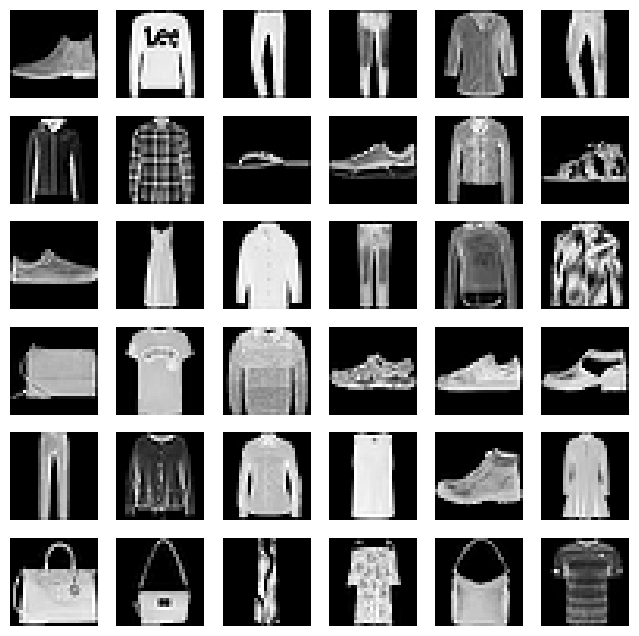

In [4]:
fig, axarr = plt.subplots(6, 6, figsize=(8, 8))
for i, ax in enumerate(axarr.flat):
    ax.imshow(test_images[i].reshape(28, 28), cmap="gray")
    ax.axis('off')

## Feedforward Network Architecture

First, we will use the keras high-level API. Then, we will re-do the task with the tensorflow low-level API.

### Model Setup

In [5]:
# Basic feedforward structure
model = keras.Sequential([
	keras.layers.Dense(128, activation= 'relu', input_shape=(784,)),
	keras.layers.Dropout(0.1),
	keras.layers.Dense(128, activation= 'relu'),
	keras.layers.Dropout(0.1),
	keras.layers.Dense(128, activation= 'relu'),
	keras.layers.Dropout(0.1),
	keras.layers.Dense(128, activation= 'relu'),
	keras.layers.Dense(10, activation= 'softmax'),
])

# Compile 
model.compile(
	loss = 'sparse_categorical_crossentropy', 
	optimizer = keras.optimizers.Adam(1e-3),
	metrics = [keras.metrics.SparseCategoricalAccuracy()]
)

# Train
h = model.fit(
	x = train_images, 
	y = train_labels, 
	epochs = 20, 
	batch_size = 32, 
	validation_split = 0.1
)

Epoch 1/20


2024-03-28 15:07:24.046260: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1688/1688 [==============================] - 3s 2ms/step - loss: 0.5497 - sparse_categorical_accuracy: 0.8021 - val_loss: 0.4065 - val_sparse_categorical_accuracy: 0.8532
Epoch 2/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4075 - sparse_categorical_accuracy: 0.8515 - val_loss: 0.4113 - val_sparse_categorical_accuracy: 0.8480
Epoch 3/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3746 - sparse_categorical_accuracy: 0.8633 - val_loss: 0.3582 - val_sparse_categorical_accuracy: 0.8650
Epoch 4/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3559 - sparse_categorical_accuracy: 0.8715 - val_loss: 0.3812 - val_sparse_categorical_accuracy: 0.8672
Epoch 5/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3409 - sparse_categorical_accuracy: 0.8730 - val_loss: 0.3656 - val_sparse_categorical_accuracy: 0.8643
Epoch 6/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3276 - sparse_categoric

In [6]:
model(train_images[:2])

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00000236, 0.        , 0.00014237, 0.        , 0.9998553 ],
       [0.9998399 , 0.        , 0.00000002, 0.00000001, 0.        ,
        0.        , 0.00016009, 0.        , 0.        , 0.        ]],
      dtype=float32)>

### Visualize Loss Trajectory

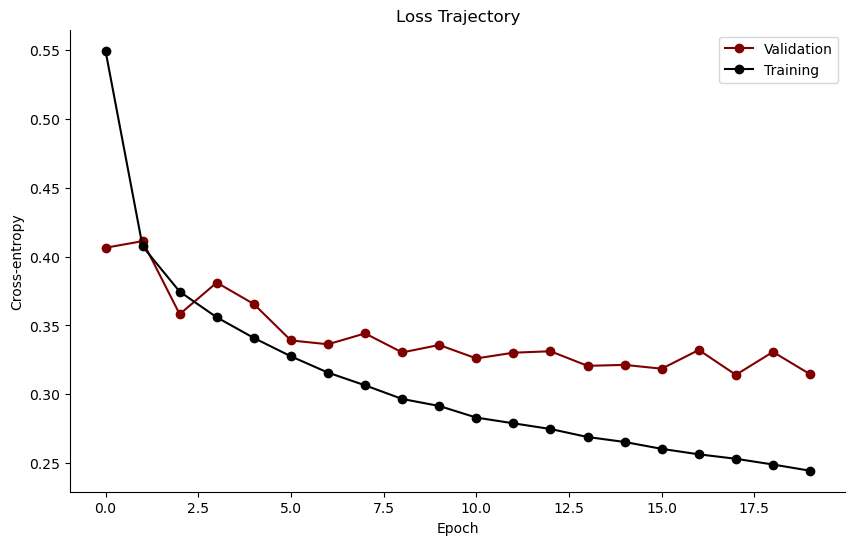

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(20), h.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(20), h.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

In [12]:
# Evaluate model on test data
### Your code here

313/313 [==============================] - 0s 1ms/step - loss: 0.3433 - sparse_categorical_accuracy: 0.8804


313/313 [==============================] - 0s 557us/step


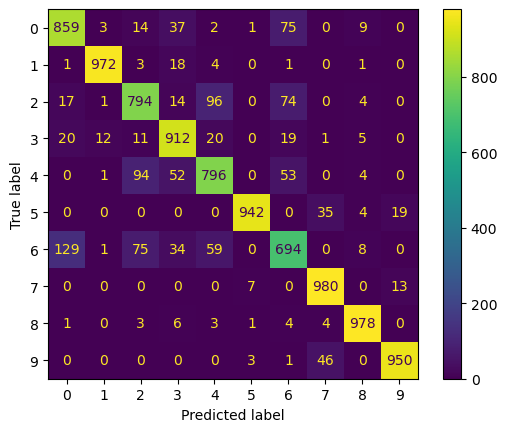

In [10]:
# More detailed evaluations
preds = model.predict(test_images)
metrics.ConfusionMatrixDisplay.from_predictions(test_labels, preds.argmax(axis=1))

## Custom Training Loop

### Model and Hyperparameters

In [21]:
# Create a TF data set
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
dataset = dataset.shuffle(buffer_size=train_images.shape[0])
dataset = dataset.batch(32)

# Create loss object
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Create optimizer
optimizer = tf.keras.optimizers.Adam(1e-4)

# Create basic feedforward model
model = keras.Sequential([
	keras.layers.Dense(128, activation= 'relu', input_shape=(784,)),
	keras.layers.Dropout(0.1),
	keras.layers.Dense(128, activation= 'relu'),
	keras.layers.Dropout(0.1),
	keras.layers.Dense(128, activation= 'relu'),
	keras.layers.Dropout(0.1),
	keras.layers.Dense(128, activation= 'relu'),
	keras.layers.Dense(10, activation= 'softmax'),
])

In [54]:
batch_images, batch_labes = next(iter(dataset))

### Custom Training Step

In [55]:
### Your code here
@tf.function
def update_step(batch_images, batch_labes, model, optimizer, loss_fn):

	with tf.GradientTape() as tape:

		# Forward Pass
		pred_labels = model(batch_images)

		# Compute Loss
		loss = loss_fn(batch_labes, pred_labels)

	# Backpropagate
	grads = tape.gradient(loss, model.trainable_variables)	# Comput Gradients
	optimizer.apply_gradients(zip(grads, model.trainable_variables))	# Update Trainable Parameters

	return loss


In [57]:
%%time
update_step(batch_images, batch_labes, model, optimizer, loss_fn)

CPU times: user 5.82 ms, sys: 2.6 ms, total: 8.42 ms
Wall time: 2.99 ms


<tf.Tensor: shape=(), dtype=float32, numpy=1.3677151>

### Custom Epoch

In [110]:
### Your code here

### Custom Training

In [19]:
# epochs = 20
# for ep in range(1, epochs+1):
#     with tqdm(total=len(dataset), desc=f"Training epoch {ep}", mininterval=0.1) as pbar:
#         l = train_epoch(dataset, model, optimizer, loss_fn, pbar)

## Explorations in Robustness

We will now explore an important question regarding the real-world pitfalls of model deployment: What is the impact of additive noise on recognition accuracy? We will systematically investigate this effect by creating a psychometric function where accuracy is plotted against stimulus visibility / noise level.

In [14]:
min_noise_level = 0
max_noise_level = 0.5
num_noise_levels = 50
noise_levels = np.linspace(min_noise_level, max_noise_level, num_noise_levels)

Let's investigate the impact of noise levels on image quality first.

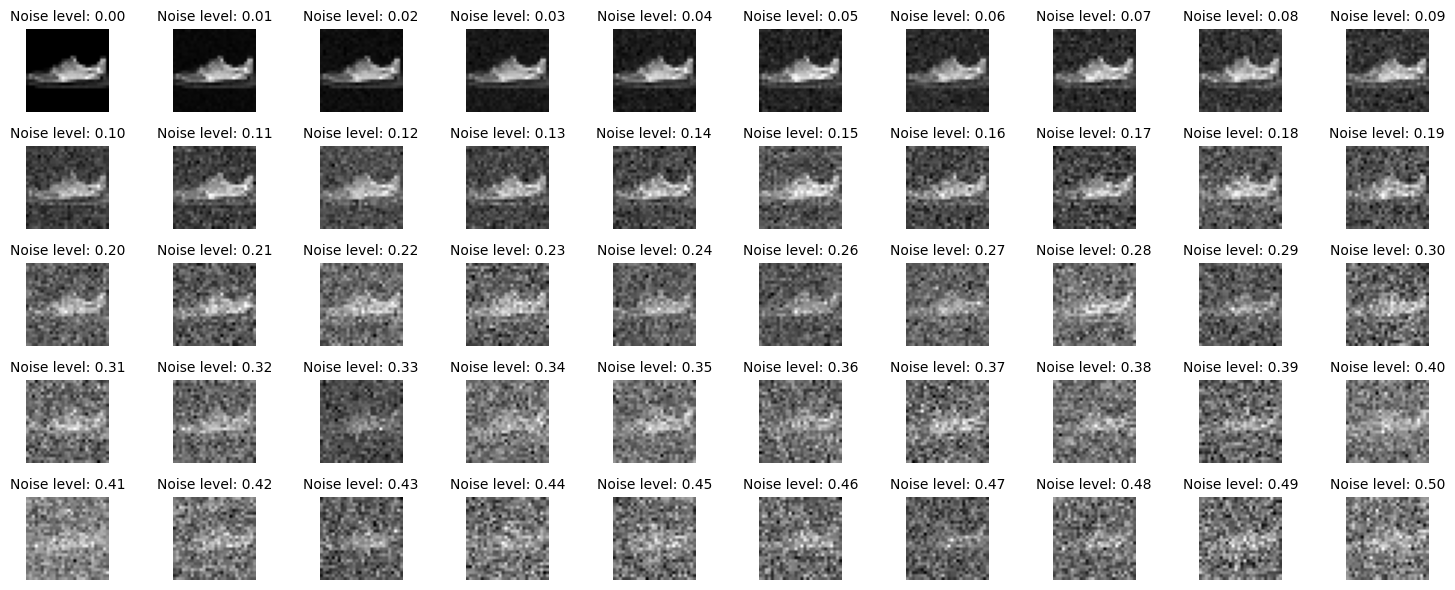

In [15]:
f, axarr = plt.subplots(5, 10, figsize=(15, 6))
random_test_image = train_images[np.random.randint(0, train_images.shape[0])]
for noise_level, ax in zip(noise_levels, axarr.flat):
    noisy_images = random_test_image + noise_level * np.random.normal(size=random_test_image.shape)
    ax.imshow(noisy_images.reshape(28, 28), cmap='gray')
    ax.set_title(f'Noise level: {noise_level:.2f}', fontsize=10)
    ax.axis('off')
f.tight_layout()

We will now iteratively add Gaussian noise with different amplitude to the test set and compute total accuracy.

In [4]:
accuracies = []
for noise_level in noise_levels:
    x_te_conv_corrupted = test_images + noise_level * np.random.normal(size=test_images.shape)
    _, accuracy = model.evaluate(x_te_conv_corrupted, test_labels)
    accuracies.append(accuracy)

What do you observe?

In [18]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(noise_levels, accuracies, '-o', color='maroon', alpha=0.9)
ax.set_xlabel('Noise Level (STD)', fontsize=18)
ax.set_ylabel('Accuracy', fontsize=18)
ax.set_title('Accuracy vs. Noise Level', fontsize=24)
ax.grid(alpha=0.3)
f.tight_layout()

## Task: Data Augmentation

Is it possible to improve recognition accuracy on the test set by injecting noise into the training data? 

Your task is to train the same neural network on augmented (noisy data) and plot its psychometric function relative to the vanilla model. There are many ways to do this!

In [5]:
### Your code here